In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_cs/'
batch_size = 256
batch_num  = 128
epoch_num  = 100
samp_num   = 7

device = torch.device("cuda:3")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [4]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    sampn = min(len(papers[_time]), batch_size)
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), sampn, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
    pids = np.stack([pids, np.repeat([_time], sampn)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list, _, _ = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'field': fids}, sampled_depth = 4, sampled_number = 100)

    el = []
    for i in edge_list['paper']['field']['rev_PF_in_L2']:
        if i[0] < len(pids):
            continue
        el += [i]
    edge_list['paper']['field']['rev_PF_in_L2'] = el

    el = []
    for i in edge_list['field']['paper']['PF_in_L2']:
        if i[1] < len(pids):
            continue
        el += [i]
    edge_list['field']['paper']['PF_in_L2'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    '''
        Trace the paper_id and field_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    field_ids = np.arange(len(fids)) + node_dict['field'][0]
    ylabel = torch.zeros(sampn, len(cand_list))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][cand_list.index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids, train_papers, valid_papers):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [5]:
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(RAGCNConv(n_hid, n_hid, num_types, num_relations, n_heads, dropout))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, node_type, edge_time, edge_index, edge_type):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = gc(meta_xs, node_type, edge_index, edge_type, edge_time)
        return meta_xs

In [6]:
'''
Paper-Field
'''
paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in graph.edge_list['field']['paper']['PF_in_L2']:
    for p_id in graph.edge_list['field']['paper']['PF_in_L2'][f_id]:
        _time = graph.edge_list['field']['paper']['PF_in_L2'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size // 2:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size // 2:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size // 2:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [7]:
types = graph.get_types()
cand_list = list(graph.edge_list['field']['paper']['PF_in_L2'])
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(types), \
          num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 4).to(device)
gnn = torch.load('../pre-train/save/mt_model.pt').to(device)
classifier = Classifier(256, len(cand_list)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

In [8]:
sel_train_papers = {}
for _time in train_papers:
    pid = train_papers[_time]
    pid = pid[np.random.choice(np.arange(len(pid)), len(pid) // 10, replace=False)]
    if len(pid) >= batch_size // 2:
        sel_train_papers[_time] = pid

In [9]:
stats = []
res = []
best_val   = 0

pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids, sel_train_papers, valid_papers)
train_step = 1500


criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(200)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids, sel_train_papers, valid_papers)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    model.train()
    train_losses = []
    torch.cuda.empty_cache()
    for batch in np.arange(2):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            torch.cuda.empty_cache()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
            del res, loss
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/rgt_2.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        del res, loss
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
            res  = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print(test_ndcg)
            del res
    del train_data, valid_data

Data Preparation: 96.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 1 (180.9s)  LR: 0.00060 Train Loss: 7.39  Valid Loss: 6.42  Valid NDCG: 0.2180
Data Preparation: 2.5s
Epoch: 2 (174.9s)  LR: 0.00069 Train Loss: 6.20  Valid Loss: 6.28  Valid NDCG: 0.2156
Data Preparation: 2.8s
Epoch: 3 (177.8s)  LR: 0.00078 Train Loss: 5.90  Valid Loss: 6.47  Valid NDCG: 0.2067
Data Preparation: 2.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 4 (172.9s)  LR: 0.00085 Train Loss: 5.92  Valid Loss: 6.21  Valid NDCG: 0.2348
Data Preparation: 2.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 5 (177.2s)  LR: 0.00091 Train Loss: 5.82  Valid Loss: 6.11  Valid NDCG: 0.2387
0.22749527090132407
Data Preparation: 8.7s
Epoch: 6 (172.8s)  LR: 0.00096 Train Loss: 5.73  Valid Loss: 6.09  Valid NDCG: 0.2162
Data Preparation: 2.6s
Epoch: 7 (174.5s)  LR: 0.00099 Train Loss: 5.69  Valid Loss: 6.02  Valid NDCG: 0.2334
Data Preparation: 2.7s
Epoch: 8 (179.3s)  LR: 0.00100 Train Loss: 5.71  Valid Loss: 6.27  Valid NDCG: 0.2155
Data Preparation: 2.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 9 (172.5s)  LR: 0.00099 Train Loss: 5.70  Valid Loss: 6.01  Valid NDCG: 0.2395
Data Preparation: 2.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 10 (176.3s)  LR: 0.00096 Train Loss: 5.66  Valid Loss: 5.88  Valid NDCG: 0.2512
0.23469957710246991
Data Preparation: 8.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 11 (176.0s)  LR: 0.00092 Train Loss: 5.69  Valid Loss: 5.88  Valid NDCG: 0.2538
Data Preparation: 2.6s
Epoch: 12 (174.0s)  LR: 0.00086 Train Loss: 5.61  Valid Loss: 6.01  Valid NDCG: 0.2501
Data Preparation: 2.8s
Epoch: 13 (171.4s)  LR: 0.00079 Train Loss: 5.67  Valid Loss: 5.97  Valid NDCG: 0.2305
Data Preparation: 2.5s
Epoch: 14 (174.8s)  LR: 0.00070 Train Loss: 5.56  Valid Loss: 5.87  Valid NDCG: 0.2440
Data Preparation: 2.4s
Epoch: 15 (175.6s)  LR: 0.00061 Train Loss: 5.58  Valid Loss: 6.12  Valid NDCG: 0.2272
0.2163968401313319
Data Preparation: 12.2s
Epoch: 16 (178.1s)  LR: 0.00051 Train Loss: 5.45  Valid Loss: 5.96  Valid NDCG: 0.2321
Data Preparation: 2.4s
Epoch: 17 (177.9s)  LR: 0.00042 Train Loss: 5.42  Valid Loss: 5.91  Valid NDCG: 0.2481
Data Preparation: 2.5s
Epoch: 18 (177.5s)  LR: 0.00032 Train Loss: 5.47  Valid Loss: 5.87  Valid NDCG: 0.2515
Data Preparation: 2.5s
Epoch: 19 (178.4s)  LR: 0.00024 Train Loss: 5.43  Valid Loss: 5.96  Valid NDCG: 0.2395
Data Preparat

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

Epoch: 42 (174.2s)  LR: 0.00097 Train Loss: 5.26  Valid Loss: 5.71  Valid NDCG: 0.2620
Data Preparation: 2.6s
Epoch: 43 (175.1s)  LR: 0.00093 Train Loss: 5.40  Valid Loss: 6.18  Valid NDCG: 0.2154
Data Preparation: 2.8s
Epoch: 44 (173.6s)  LR: 0.00088 Train Loss: 5.29  Valid Loss: 5.98  Valid NDCG: 0.2327
Data Preparation: 2.8s
Epoch: 45 (173.0s)  LR: 0.00081 Train Loss: 5.35  Valid Loss: 5.90  Valid NDCG: 0.2309
0.2079149809095189
Data Preparation: 8.4s
Epoch: 46 (177.1s)  LR: 0.00072 Train Loss: 5.12  Valid Loss: 5.94  Valid NDCG: 0.2526
Data Preparation: 2.8s
Epoch: 47 (180.0s)  LR: 0.00063 Train Loss: 5.09  Valid Loss: 5.99  Valid NDCG: 0.2510
Data Preparation: 2.8s
Epoch: 48 (178.8s)  LR: 0.00054 Train Loss: 5.28  Valid Loss: 5.79  Valid NDCG: 0.2615
Data Preparation: 3.0s
Epoch: 49 (176.2s)  LR: 0.00044 Train Loss: 4.97  Valid Loss: 6.04  Valid NDCG: 0.2306
Data Preparation: 2.7s
Epoch: 50 (171.8s)  LR: 0.00035 Train Loss: 5.13  Valid Loss: 5.87  Valid NDCG: 0.2477
0.229993035955

Epoch: 114 (177.0s)  LR: 0.00039 Train Loss: 4.99  Valid Loss: 6.27  Valid NDCG: 0.2210
Data Preparation: 2.5s
Epoch: 115 (171.9s)  LR: 0.00030 Train Loss: 4.93  Valid Loss: 6.00  Valid NDCG: 0.2240
0.22833038925568463
Data Preparation: 12.5s
Epoch: 116 (174.0s)  LR: 0.00022 Train Loss: 5.00  Valid Loss: 6.40  Valid NDCG: 0.2172
Data Preparation: 2.6s
Epoch: 117 (174.5s)  LR: 0.00014 Train Loss: 5.14  Valid Loss: 6.03  Valid NDCG: 0.2294
Data Preparation: 3.1s
Epoch: 118 (177.1s)  LR: 0.00008 Train Loss: 4.74  Valid Loss: 6.05  Valid NDCG: 0.2212
Data Preparation: 2.6s
Epoch: 119 (173.7s)  LR: 0.00004 Train Loss: 5.02  Valid Loss: 5.96  Valid NDCG: 0.2345
Data Preparation: 2.5s
Epoch: 120 (169.9s)  LR: 0.00001 Train Loss: 5.03  Valid Loss: 5.89  Valid NDCG: 0.2352
0.2525720273865802
Data Preparation: 8.0s
Epoch: 121 (173.2s)  LR: 0.00000 Train Loss: 4.80  Valid Loss: 6.08  Valid NDCG: 0.2305
Data Preparation: 2.6s
Epoch: 122 (173.4s)  LR: 0.00001 Train Loss: 4.95  Valid Loss: 6.24  Val

0.22156268425938283
Data Preparation: 8.1s
Epoch: 186 (112.2s)  LR: 0.00000 Train Loss: 4.83  Valid Loss: 6.18  Valid NDCG: 0.2276
Data Preparation: 3.3s
Epoch: 187 (110.8s)  LR: 0.00002 Train Loss: 4.69  Valid Loss: 6.34  Valid NDCG: 0.2117
Data Preparation: 2.6s
Epoch: 188 (111.2s)  LR: 0.00006 Train Loss: 4.75  Valid Loss: 6.51  Valid NDCG: 0.2099
Data Preparation: 3.0s
Epoch: 189 (110.6s)  LR: 0.00011 Train Loss: 4.94  Valid Loss: 6.29  Valid NDCG: 0.2201
Data Preparation: 2.6s
Epoch: 190 (112.8s)  LR: 0.00018 Train Loss: 4.72  Valid Loss: 6.35  Valid NDCG: 0.2120
0.20261825900795805
Data Preparation: 8.6s
Epoch: 191 (112.0s)  LR: 0.00026 Train Loss: 4.83  Valid Loss: 6.26  Valid NDCG: 0.2136
Data Preparation: 2.9s
Epoch: 192 (111.0s)  LR: 0.00035 Train Loss: 4.80  Valid Loss: 6.25  Valid NDCG: 0.2283
Data Preparation: 2.9s
Epoch: 193 (112.5s)  LR: 0.00045 Train Loss: 4.87  Valid Loss: 6.29  Valid NDCG: 0.2202
Data Preparation: 3.1s
Epoch: 194 (111.9s)  LR: 0.00054 Train Loss: 4.77

In [10]:
print(1)

1


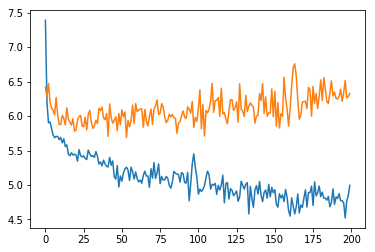

In [11]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [12]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.22045195339068963 0.011593240643793822
0.12456766218936549 0.05375850098311576


In [13]:
best_model = torch.load('./save/rgt_3.pt')

In [14]:
best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.236616592641577 0.013070808861716451
0.1574382906714827 0.06872145473002399


In [15]:
# without pre-train

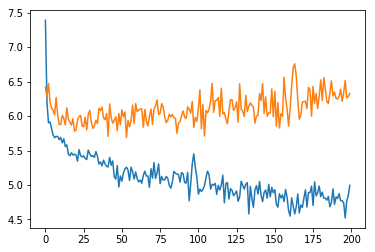

In [16]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [17]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))
    
best_model = torch.load('./save/rgt_1.pt')

best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.210535960603455 0.009495918391629833
0.1073049305922487 0.04343959429308031


RuntimeError: arguments are located on different GPUs at /opt/conda/conda-bld/pytorch_1570910687650/work/aten/src/THC/generic/THCTensorMathBlas.cu:277

In [ ]:
l2_fields = graph.node_feature['field'][graph.node_feature['field']['attr'] == 'L2'].index.values

In [ ]:
graph.node_feature['field'].iloc[[l2_fields[424]]]

In [ ]:
graph.node_feature['field'].iloc[[l2_fields[637]]]

In [ ]:
l2_fields[424], l2_fields[637]

In [ ]:
papers = []
mxn = 0
for f in l2_fields:
    p = graph.edge_list['field']['paper']['PF_in_L2'][f]
    if len(p) > 100 and len(p) < 10000:
        papers += [p]
len(papers)

In [ ]:
citation_matrix = np.zeros([len(papers), len(papers)])

In [ ]:
for i1, j1 in enumerate(papers):
    if i1 % 10 == 0:
        print('%d / %d' % (i1, len(papers)))
    for i2, j2 in enumerate(papers):
        if i2 > i1: 
            continue
        cnt = 0
        for p1 in j1:
            for p2 in graph.edge_list['paper']['paper']['PP_cite'][p1]:
                if p2 in j2:
                    cnt += 1
        citation_matrix[i1][i2] = cnt / len(j1) / len(j2)

In [ ]:
possible_ls = []
th = 0.002
for i in range(len(citation_matrix)):
    for j in range(len(citation_matrix)):
        if i >= j:
            inter = citation_matrix[i][j]
            left  = citation_matrix[i][i]
            right = citation_matrix[j][j]
#             if inter>th and left >= inter and right >= 0.7 * left and right <= left and right>=inter:
            if inter>th and left >= inter and right>=inter:
                if len(list(papers[i].keys()))>=2.5*len(list(papers[j].keys())):
                    print(i,j, len(list(papers[i].keys())), len(list(papers[j].keys())))
                    possible_ls.append([i,j])

In [ ]:
paper_list_0 = list(papers[637].keys())
paper_list_1 = list(papers[424].keys())
print(len(paper_list_0), len(paper_list_1))
_papers = paper_list_0 + paper_list_1
paper_id = {j:i for i, j in enumerate(_papers)}
paper_labels = {}
for p in paper_list_0:
    paper_labels[p] = 0
for p in paper_list_1:
    paper_labels[p] = 1

In [ ]:
_papers = paper_list_0 + paper_list_1
paper_id = {j:i for i, j in enumerate(_papers)}
paper_labels = {}
for p in paper_list_0:
    paper_labels[p] = 0
for p in paper_list_1:
    paper_labels[p] = 1

In [ ]:
edges = []
degrees = defaultdict(lambda: 0)
for pi in _papers:
    for pj in  graph.edge_list['paper']['paper']['PP_cite'][pi]:
        if pj in paper_id:
            edges += [paper_id[pi], paper_id[pj]]
            edges += [paper_id[pj], paper_id[pi]]
            degrees[pi] += 1
            degrees[pj] += 1

In [ ]:
removes = {}
for p in paper_list_0:
    if degrees[p] <= 5 or degrees[p] > 60:
        removes[p] = True
for p in paper_list_1:
    if degrees[p] <= 20 or degrees[p] > 60:
        removes[p] = True
_papers = [p for p in _papers if p not in removes]
paper_id = {j:i for i, j in enumerate(_papers)}

In [ ]:
edges = []
degrees = defaultdict(lambda: 0)
rec = {}
for pi in _papers:
    for pj in graph.edge_list['paper']['paper']['PP_cite'][pi]:
        if pj in paper_id:
            if pi != pj:
                e = [[paper_id[pi], paper_id[pj]]]
                if "%d_%d" % (paper_id[pi], paper_id[pj]) not in rec:
                    edges += [[paper_id[pi], paper_id[pj]]]
                    edges += [[paper_id[pj], paper_id[pi]]]
                    rec["%d_%d" % (paper_id[pi], paper_id[pj])] = True
                    rec["%d_%d" % (paper_id[pj], paper_id[pi])] = True
                    degrees[pi] += 1
                    degrees[pj] += 1

In [ ]:
features = np.array(list(graph.node_feature['paper'].loc[_papers, 'emb']))

In [ ]:
labels = []
paper_list_0 = []
paper_list_1 = []
for p in _papers:
    labels.append(paper_labels[p])
    if paper_labels[p] == 0:
        paper_list_0 += [p]
    if paper_labels[p] == 1:
        paper_list_1 += [p]
print(len(paper_list_0), len(paper_list_1))

In [ ]:
cnt = defaultdict(lambda: 0)
for l in labels:
    cnt[l] += 1
cnt

In [ ]:
dill.dump((edges, features, labels), open('./data.pk', 'wb'))

In [ ]:
[len(paper_list_0), len(paper_list_1)]

In [ ]:
tr = defaultdict(lambda: defaultdict(lambda: 0))
for e in np.array(edges).reshape(-1, 2):
    tr[labels[e[0]]][labels[e[1]]] += 1

In [ ]:
tr[0][0] / len(paper_list_0) / len(paper_list_0)

In [ ]:
tr[0][1] / len(paper_list_0) / len(paper_list_1)

In [ ]:
tr[1][1] / len(paper_list_1) / len(paper_list_1)

In [ ]:
tr[1][1]

In [ ]:
len(paper_list_1) * len(paper_list_1)